<a href="https://colab.research.google.com/github/vparonov/AIPlayground/blob/main/MagicDarts_2021_03_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
#20210223121450_cut_share.h5
#20210224094951_cut_share.h5

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
import h5py
import numpy as np
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [81]:
datafileName = 'drive/MyDrive/darts_data/20210223121450_cut_share.h5'
#datafileName = 'drive/MyDrive/darts_data/vangel_2021_03_04_01_edited_cut_share.h5'

In [82]:
f = h5py.File(datafileName,'r')
f.keys()


<KeysViewHDF5 ['cur_time', 't_hit', 'trajectory', 'vx_cur_clear', 'vx_cur_esti', 'vx_cur_esti_cart', 'vy_cur_clear', 'vy_cur_esti', 'vy_cur_esti_cart', 'vz_cur_clear', 'vz_cur_esti', 'vz_cur_esti_cart', 'x_cur_clear', 'x_hat_0', 'x_hat_lat', 'x_results_real', 'y_cur_clear', 'y_hat_0', 'y_hat_lat', 'y_results_real', 'z_cur_clear', 'z_hat_0', 'z_hat_lat', 'z_results_real']>

In [83]:
# original source: https://github.com/Marchetz/Trajectories-Prediction-Kalman/blob/master/KalmanFilter.py
class KalmanFilter:

    def __init__(self, F, H, P0, Q, R0):
        self.m = H.shape[0]
        self.n = H.shape[1]
        self.F = F

        self.H = H

        self.K = np.zeros((self.n, self.m))

        self.P = P0

        self.R = R0

        self.Q = Q

    def fit(self, xhat_previous, z_k):
        # prediction
        xhat_k_minus = self.predict(xhat_previous)  # predict updates self.P (P_minus)
        P_minus = self.P

        # correction
        inv_HPHTR = np.linalg.inv(np.dot(np.dot(self.H, P_minus), self.H.T) + self.R)
        self.K = np.dot(np.dot(P_minus, self.H.T), inv_HPHTR)

        residual = z_k - np.dot(self.H, xhat_k_minus)
        xhat_k_new = xhat_k_minus + np.dot(self.K, residual)

        self.P = np.dot((np.eye(self.n) - np.dot(self.K, self.H)), P_minus)

        return xhat_k_new

    def predict(self, xhat_k_previous):
        xhat_k_minus = np.dot(self.F, xhat_k_previous)  # update previous state estimate with state transition matrix

        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q  # this is P minus

        return xhat_k_minus

In [84]:
class MagicDartsDataset(Dataset):
    """Magic Darts Dataset"""

    def __init__(self, h5_file, transform=None):
        """
        Args:
            h5_file (string): Path to the h5 file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.f = h5py.File(datafileName,'r')
        dshape = f['cur_time'].shape
        self.dataShape = dshape[:-1]
        self.timeDimSize = dshape[-1]

        self.dataLen = self.getDataLen()
        self.transform = transform
        self.x_keys = [#'cur_time', 
                      'x_hat_0', 'y_hat_0', 'z_hat_0',
                      'vx_cur_esti','vy_cur_esti','vz_cur_esti']
        self.y_keys = ['x_results_real','z_results_real']

    def getDataLen(self):
        nitems = 1 
        for s in self.dataShape:
          nitems *= s

        return nitems

    def indexToDims(self, idx):
        dataIndex = ()
        index = idx
        for s in self.dataShape:
          dataIndex += (index % s,)
          index = index // s
        return dataIndex

    def __len__(self):
        return self.dataLen

    def __getitem__(self, idx):
   
        sliceIx = self.indexToDims(idx)

        x = torch.empty((self.timeDimSize, len(self.x_keys)))
        y = torch.empty((len(self.y_keys)))

        for i, k in enumerate(self.x_keys):
          x[:,i] = torch.tensor(self.f[k][sliceIx])

        for i, k in enumerate(self.y_keys):
          yy = self.f[k][(sliceIx)][0]
          y[i] = torch.tensor(yy)
        
        #x[torch.isnan(x)] = 0

        sample = {'x': x, 'y': y}

        if self.transform:
            sample = self.transform(sample)
          
        return sample


In [85]:
def getFirstN(n):
  return lambda sample: {'x': sample['x'][:n,:], 'y': sample['y']}

def getRandomN(n, max_time_points):
  all_ixes = np.arange(max_time_points)
  def f(sample):
      np.random.shuffle(all_ixes)
      ixes = np.sort(all_ixes[:(max_time_points - n)])
      x = sample['x']
      x[ixes, :] = torch.tensor(float('nan'))
      return {'x': x, 'y': sample['y']}
  return f

In [86]:
class LSTMTrial3(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
    super(LSTMTrial3, self).__init__()

    self.input_size = input_size 
    self.hidden_size = hidden_size
    self.output_size = output_size 
    self.num_layers = num_layers 
 
    self.fc_1 =  nn.Linear(input_size, 128) #fully connected 1
    self.fc_2 =  nn.Linear(input_size, 128) #fully connected 2
    self.fc = nn.Linear(128, output_size) #fully connected last layer

    self.lstm = nn.LSTM(input_size=output_size, hidden_size=hidden_size,
                    num_layers=num_layers, 
                    batch_first=True, 
                    dropout=dropout) #lstm

    self.fc_out =  nn.Linear(hidden_size, output_size) #fc output
  
    self.relu = nn.ReLU() 

  def forward(self,x):

      x[torch.isnan(x)] = 1000

      hidden = self.fc_1(x) #first Dense

      hidden = self.relu(hidden) 

      #hidden = self.fc_2(x) #second Dense

      #hidden = self.relu(hidden) 

      hidden = self.fc(hidden) #
       
      h_0 = Variable(torch.zeros(
            self.num_layers, hidden.size(0), self.hidden_size)).to('cuda') #hidden state
      
      c_0 = Variable(torch.zeros(
          self.num_layers, hidden.size(0), self.hidden_size)).to('cuda') #internal state
    
      # Propagate input through LSTM

      output, (hn, cn) = self.lstm(hidden, (h_0, c_0)) #lstm with input, hidden, and internal state

      h = hn[-1,:,:].view(-1, self.hidden_size)

      #h = self.relu(hn) #relu

      #print("hn = ", hn)
      out = self.fc_out(h)
      #print("out = ", out)
      return out 

In [87]:
ds = MagicDartsDataset(datafileName, transform = getRandomN(10, 52))

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

print(len(train_dataset), len(test_dataset))

batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


64 17


In [101]:
learning_rate = 0.0001 

input_size = 6 
hidden_size = 128
num_layers = 1

output_size = 2 
dropout  = 0

model = LSTMTrial3(input_size = input_size, 
                   hidden_size = hidden_size, 
                   output_size = output_size, 
                   num_layers = num_layers, 
                   dropout = dropout)

def distance(y_hat, y):
  return torch.sqrt((y_hat[:,0]-y[:,0])**2 + (y_hat[:,1]-y[:,1])**2).mean()

criterion = torch.nn.MSELoss()    # mean-squared error for regression

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(ds.timeDimSize)

52


Epoch: 0, loss: 0.2216261327
Epoch: 1, loss: 0.3905606866
Epoch: 2, loss: 0.1523945034
Epoch: 3, loss: 0.1513401270
Epoch: 4, loss: 0.1483094990
Epoch: 5, loss: 0.1872926801
Epoch: 6, loss: 0.2614708245
Epoch: 7, loss: 0.1756412685
Epoch: 8, loss: 0.0694925636
Epoch: 9, loss: 0.1373656541
Epoch: 10, loss: 0.0737732202
Epoch: 11, loss: 0.1423565447
Epoch: 12, loss: 0.0496759415
Epoch: 13, loss: 0.0282080472
Epoch: 14, loss: 0.0477327481
Epoch: 15, loss: 0.0233928785
Epoch: 16, loss: 0.0418160371
Epoch: 17, loss: 0.1188097447
Epoch: 18, loss: 0.0360285230
Epoch: 19, loss: 0.1603191048
Epoch: 20, loss: 0.2294867039
Epoch: 21, loss: 0.0262713544
Epoch: 22, loss: 0.0680546910
Epoch: 23, loss: 0.0629091114
Epoch: 24, loss: 0.0327929221
Epoch: 25, loss: 0.0692003518
Epoch: 26, loss: 0.0254022293
Epoch: 27, loss: 0.2017537355
Epoch: 28, loss: 0.2355908751
Epoch: 29, loss: 0.0730808675
Epoch: 30, loss: 0.0553750396
Epoch: 31, loss: 0.0283644758
Epoch: 32, loss: 0.0617768914
Epoch: 33, loss: 0.0

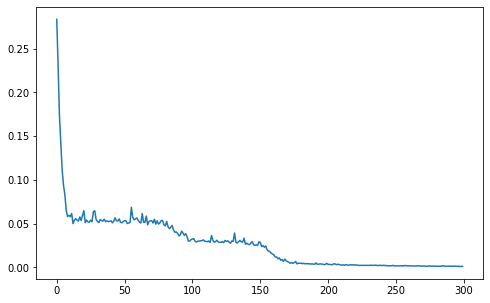

In [102]:
#model = model.float()
num_epochs = 300
epoch_loss = []
model.train()
for epoch in range(num_epochs):
  current_loss = 0 
  for batch, sample in enumerate(train_dataloader):
    #print(sample['x'].permute(.shape)
    #print("x=", sample['x'])
    outputs = model.forward(sample['x'].to(device)) #forward pass
    #print("outputs=", outputs)
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    #print(outputs.shape)
    # obtain the loss function
    loss = criterion(outputs, sample['y'].to(device))
    loss.backward() #calculates the loss of the loss function
    current_loss += loss.item()
    optimizer.step() #improve from loss, i.e backprop
    #print("loss: %1.5f" % (loss.item())) 
  epoch_loss.append(current_loss / batch_size)
  print("Epoch: %d, loss: %1.10f" % (epoch, loss.item())) 

plt.plot(epoch_loss)
plt.show()

In [103]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset),
                        shuffle=True, num_workers=0)

model.eval()
for batch, sample in enumerate(test_dataloader):
  with torch.no_grad():
    outputs = model.forward(sample['x'].to(device)) #forward pass  
    loss = criterion(outputs, sample['y'].to(device))
    print(loss)



tensor(0.0070, device='cuda:0')


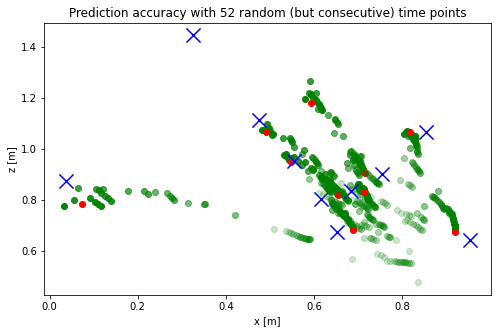

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.39746962 0.33388079 0.32073305
 0.32156325 0.32415709 0.3138681  0.30239066 0.26163093 0.26777869
 0.26521584 0.26816378 0.24591709 0.25477522 0.26144733 0.24945856
 0.24361177 0.21997571 0.20985411 0.18074805 0.18950005 0.17378461
 0.15435794 0.1536032  0.14904748 0.14311783 0.13996325 0.14339744
 0.14252077 0.11548442 0.1046065  0.08901084 0.09789759 0.09978966
 0.09925948 0.09622185 0.09014275 0.08341068 0.08329463 0.08725858
 0.09005335 0.08633281 0.07678197 0.07678443]


In [104]:
max_time_points = 52
max_traj = 10

#ds = MagicDartsDataset('drive/MyDrive/darts_data/20210224094951_cut_share.h5') 

test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
#test_dataloader = DataLoader(ds, batch_size=1,
#                        shuffle=True, num_workers=0)

distances = np.zeros(shape=(max_traj,max_time_points))


model.eval()
for batch, sample in enumerate(test_dataloader):
  if batch == max_traj:
    break 
  with torch.no_grad():
    x_full = sample['x'].to(device) 
    y_full = sample['y'].to(device)
    l = []
    for i in range(10, max_time_points+1):
      ixes = np.arange(i)
      #ixes = np.arange(start=1, stop=i, step=10) #odd indices
      #ixes = np.sort(np.random.choice(np.arange(max_time_points+1), i))
      #print(ixes)
      x_trial = x_full[:,(ixes),:]
      
      outputs = model.forward(x_trial) #forward pass  
      loss = criterion(outputs, y_full)
      l.append(loss.item())
      
      hp_x_hat = outputs[0,0].item()
      hp_z_hat = outputs[0,1].item()
      hp_x = y_full[0, 0].item()
      hp_z = y_full[0, 1].item()

      distance = np.sqrt((hp_x_hat - hp_x)**2 + (hp_z_hat - hp_z)**2)

      distances[batch, i-1] = distance


      #print(i)
      if i == max_time_points:
        c = 'r'
      else:
        c = 'g'
      plt.scatter(outputs[0, 0].item(), outputs[0, 1].item(),alpha=(i/max_time_points), c=c)
    plt.scatter(y_full[0, 0].item(), y_full[0, 1].item(), c='b', marker='x', s=200)
  
plt.title(f'Prediction accuracy with {max_time_points} random (but consecutive) time points')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.show()

print(distances.mean(axis=0))

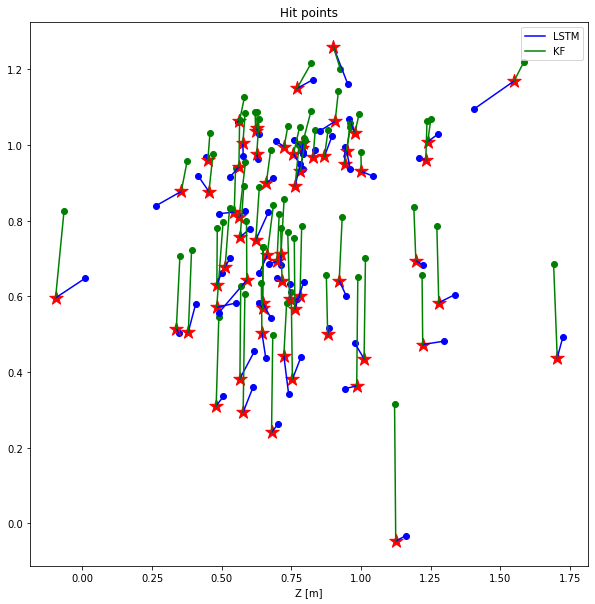

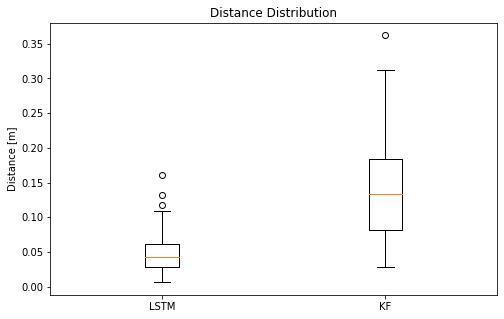

In [109]:
# test Kalman filter

plt.rcParams["figure.figsize"] = (10,10)

dt = 5e-3 # time step 

F = np.array([
              [1, 1 * dt, 0,      0, 0.5 * dt * dt,             0],  # x
              [0,      1, 0,      0,        1 * dt,             0],  # x'

              [0,      0, 1, 1 * dt,             0, 0.5 * dt * dt],  # y
              [0,      0, 0,      1,             0,        1 * dt],  # y'

              [0,      0, 0,      0,             1,             0],  # x''
              [0,      0, 0,      0,             0,             1]]) # y''

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]              
              ])

m_dim, n_dim = H.shape
q = np.diag(np.full(n_dim, 0.00001))
r = np.diag(np.full(m_dim, 0.00001))
p0 = np.diag(np.full(n_dim, 0.00001))

k_filter = KalmanFilter(F, H, P0=p0, Q=q, R0=r)

#ds = MagicDartsDataset('drive/MyDrive/darts_data/20210224094950_cut_share.h5', 
 #                      transform = getRandomN(10, 52)) 
#ds = MagicDartsDataset('drive/MyDrive/darts_data/vangel_2021_03_04_01_edited_cut_share.h5', 
#                       transform = getRandomN(10, 52)) 
#ds = MagicDartsDataset('drive/MyDrive/darts_data/20210224094951_cut_share.h5') 

#test_dataloader = DataLoader(ds, batch_size=1,
#                        shuffle=True, num_workers=0)

test_dataloader = DataLoader(train_dataset, batch_size=1,
                            shuffle=False, num_workers=0)


#x_hat_0', 'y_hat_0', 'z_hat_0','vx_cur_esti','vy_cur_esti','vz_cur_esti']
#self.y_keys = ['x_results_real','z_results_real'
#
errors = []
errors_lstm = []

for batch, sample in enumerate(test_dataloader):
  x = sample['x'] 
  y = sample['y']

  with torch.no_grad():
    x_full = x.to(device) 
    outputs = model.forward(x_full) #forward pass  
    
    hp_x_hat = outputs[0,0].item()
    hp_z_hat = outputs[0,1].item()
    hp_x = y[0, 0].item()
    hp_z = y[0, 1].item()

    plt.scatter(hp_x_hat, hp_z_hat,c="b")
    plt.plot([hp_x_hat,hp_x], [hp_z_hat,hp_z], c='b',label="LSTM")

    errors_lstm.append(np.sqrt((hp_x_hat - hp_x)**2 + (hp_z_hat - hp_z)**2))

  nsteps = x.shape[1]
  minix = 0
  for ix, v in enumerate(torch.isnan(x[0,:,0])):
    if not v.item():
      minix = ix
      break

  firstStep = x[0,minix]
  x_hat_previous = np.array([firstStep[0], firstStep[3], firstStep[1], firstStep[4], firstStep[2], firstStep[5]])
 
  c = 'r' # colour of the real hit point
  hitpointMarker = 'x'
  hasData = np.ones(52)

  for s in range(minix, nsteps):
    currentStep = x[0, s]
    if torch.isnan(currentStep).sum() >0 :
      #if missing data is detected, the colour and the marker are changed for better visibility
      hasData[s] = 0 
      c = 'r'
      hitpointMarker = '*'
      x_hat_new = k_filter.predict(x_hat_previous)
      x_hat_previous = x_hat_new
      continue

    z_k = np.array([currentStep[0], currentStep[3], currentStep[1], currentStep[4], currentStep[2], currentStep[5]])
    x_hat_new = k_filter.fit(x_hat_previous, z_k)  # predict and correct
    x_hat_previous = x_hat_new
  
  while x_hat_new[2] > 0 and x_hat_new[4] > 0:
    x_hat_new = k_filter.predict(x_hat_previous)
    x_hat_previous = x_hat_new
  
  plt.scatter(x_hat_new[0], x_hat_new[4],c="g")
  plt.plot([x_hat_new[0],hp_x], [x_hat_new[4],hp_z], c='g', label="KF")

  plt.scatter(y[0, 0].item(), y[0, 1].item(), c=c, marker=hitpointMarker, s=200)

  errors.append(np.sqrt((x_hat_new[0]-y[0, 0].item())**2+(x_hat_new[4]-y[0, 1].item())**2))

plt.title('Hit points')
plt.legend(['LSTM', 'KF'])
plt.xlabel('X [m]')
plt.xlabel('Z [m]')
plt.show()

plt.rcParams["figure.figsize"] = (8,5)
#plt.boxplot(errors)
plt.title('Distance Distribution')
plt.boxplot([errors_lstm, errors])
plt.ylabel('Distance [m]')
plt.xticks(ticks=[1, 2], labels=['LSTM', 'KF'])
plt.show()
#x_hat_previous = np.array([x0, v0x, y0, v0y, 0, 0])